# Plotting figures for 4D North Pacific variability
## Created By Dani Lafarga 1/8/2026
Program will plot figures for the paper "Four-dimensional North Pacific variability and regional impacts from a high-resolution ocean reanalysis." This paper calculates 3D EOFs from the eddy-resolving GLORYS data that can be found at [the Copernicus Marine Environment Monitoring Service website](https://data.marine.copernicus.eu/product/GLOBAL_MULTIYEAR_PHY_001_030/description).

The domain used for the calculation are:
- latitude: $20^{\circ}$S - $70^{\circ}$N,
- longitude: $120^{\circ}$E - $60^{\circ}$W, and
- depth: Surface - $541.09$ meters.

The code to calculate the EOFs can be found at [this repository](https://github.com/dlafarga/PIM-for-Computing-3D-EOFs). Be sure to specify the latitude and longitude indices correctly with the domain above to calculate the 3D EOFs. Calculating the 3D EOFs is not required to run this code as they are saved in this repository. 


NOTE: The code for each figure can be very repeatative so in depth comments are added only to the first few portions of the code. Comments are minimal for the repetative potions to limit crowding.

The code is outlined as such:

- **Section 1**: Plots the first two figures of the paper. These figures include EOFs and PCs computed from GLORYS North Pacific ocean temperatures. 

- **Section 2**: Plots the C and E index calculated by rotating the PCs and EOFs by 45$^\circ$

- **Section 3**: Plots the regional patterns for the E and C index

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/dlafarga/4D-North-Pacific-Variability/blob/main/Plot_Figures.ipynb)

In [203]:
import os
import numpy as np
from numpy import linspace
from numpy import meshgrid
import math

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

from mpl_toolkits.basemap import Basemap
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

import netCDF4 as nc
from netCDF4 import Dataset as ds
import pandas as pd
#################################################################################################################
#################################################################################################################
# Function will set main data directory
# Input:
# Output: None as the function will only be setting the directories to read from 
# Important Variables:
#         - data_directory: directory with the raw GLORYs data
def set_directory():
    global data_directory
    data_directory = os.getcwd()
    return
set_directory()
#################################################################################################################
#################################################################################################################
# Function get_var() will save common variables that will be required for climatologies and EOFs
# Output: 
#         - lat: 1d array with all latitude values
#         - lon: 1d array with all longitude values
#         - depth: 1d array with all depth values
#         - years: 1d array with all year values
def get_var():
    fn     = 'EOF_1.nc'
    fn     = os.path.join(data_directory, fn)
    fn     =  ds(fn,'r')
    lat    = fn.variables['lat'][:].data    # read in latitude
    lon    = fn.variables['lon'][:].data    # read in longitude
    depths = fn.variables['depth'][:].data  # read in depth
    fn.close()
    return lat, lon, depths
#################################################################################################################
#################################################################################################################
# Function compute volume weights based on latitude and depth values. Although longitude values are not
# in the equation the length of the longitude array is necessary for building 3D volume weight array 
# Input:
#         - depth: 1d array with all depth values
#         - lon: 1d array with all longitude values
#         - lat: 1d array with all latitude values
# Output: 
#         - volume_weight: 3D array with volume weights
def vol_weight(depths, lon, lat):
    xx, yy = meshgrid(lon, lat)
    tot_depth = len(depths)
    
    # area weight for lattitude values
    area_w = np.cos(yy*math.pi/180)
    if lat[-1] == 90.0:
        area_w[-1,:] = 0.0
    # area weights for depth
    volume_weight = []
    for i in range(tot_depth):
        if i == 0:
            volume_weight.append(np.sqrt(depths[0] * area_w)) # first depth thickness is from surface to this point
        else:
            volume_weight.append( np.sqrt((depths[i] - depths[i - 1]) * area_w)) # all other depth layers are a difference
    # Turning weights into one array
    volume_weight = np.array(volume_weight)
    return volume_weight  
#################################################################################################################
#################################################################################################################
# Function will read one EOF mode 
# Input:
#         - fn: string with the file name of the EOF. This will either be 'EOF_1.nc' or 'EOF_2.nc'
# Output:
#         - EOF: 3D float array with the EOF at a defined cut
def read_EOFs(fn):
    fn     = os.path.join(data_directory, fn) # attach to directory
    EOF_ncfile = ds(fn, 'r')
    EOF = EOF_ncfile.variables['EOF'] # reading in EOF
    EOF = EOF[:].filled()
    EOF_ncfile.close()
    volume_weight = vol_weight(depths, lon, lat)
    EOF = EOF/volume_weight  # remember to div by volume weight 
    return EOF
#################################################################################################################
#################################################################################################################
# Function wil read climatologies for the North Pacific. 
# Important variables:
#        - depth_end: Int defining what depth level to stop it
#        - lat_start: Int defining which lat to start at
#        - lat_end: Int defining which lat to stop at
#        - lon_start: Int defining which lon to start
#        - lon_end: Int defining which lon to end at
# Output:
#         - clim: 3D float array with the climatologies at a defined cut
def read_clim():
    lat_start = 720   # start at 20S
    lat_end   = 1801  # end at 70N
    lon_start = 1440  # start at 120E
    lon_end   = 3600  # end at 60W
    depth_end = 32    # end at 541.09 meters
    fn = 'Winter.mon.clim.nc'
    # read in climatologies 
    fn   = os.path.join(data_directory, fn)
    nc0  = ds(fn, 'r')
    clim = nc0.variables['clim'][0:depth_end, lat_start:lat_end, lon_start:lon_end]
    nc0.close()
    return clim
#################################################################################################################
#################################################################################################################
# Function will read in eigenvalues and eigenvectors saved in CSV file based on the EOF_directory
# Input: None
# Output:
#         - eigvals: a 1D float array with all eigenvectors corresponding eigenvalues
#         - eigvecs: a 2D float array with all eigenvectors in the columns of the matrix
def read_evec():
    # Read the CSV file for eigenvalues and eigen vectors
    fn     = 'Winter Avg_eigenvalues_eigenvectors.csv'
    fn     = os.path.join(data_directory, fn)
    df     = pd.read_csv(fn)
    # Extract the eigenvalues
    eigvals = df['Eigenvalue'].values

    # Extract the eigenvectors
    eigvecs = df.drop(columns=['Eigenvalue']).values.T
    return eigvals,eigvecs
#################################################################################################################
#####################               Plotting formatting functions                    ############################
#################################################################################################################
#################################################################################################################
# Function will create a custom colormap with specified total color values
# Input: 
#         - number_bins: int that specifies the number of colors for each half of the diveriging colorbar
# Output:
#         - newcmp2: a custom diverging colormap
def create_colormap(number_bins):
    top2 = cm.get_cmap('GnBu_r')
    bottom2 = cm.get_cmap('hot_r')
    top_array = top2(np.linspace(0, 1, number_bins))
    bottom_array = bottom2(np.linspace(0, .9, number_bins))
    top_array[-1:,:] = bottom_array[0,:]
    newcolors2 = np.vstack((top_array, bottom_array))
    newcmp2 = ListedColormap(newcolors2, name='OrangeBlue')
    return newcmp2
#################################################################################################################
#################################################################################################################
# Function converts a latitude value from the lat variable into a string for a title. 
# ex:
#         -20 = 20S
# Input:
#         - lat_ind: int that specifies index of latitude. This value will be converted to a string for a title
# Output:
#         - lat_name: string with the added S or N 
def get_lat_names(lat_ind):
    lat_name = int(lat[lat_ind])
    if lat_name< 0:
        lat_name =  f"{abs(lat_name)}$^\circ$S"
    elif lat_name == 0:
        lat_name = 'Equator'
    else:
        lat_name =  f"{lat_name}$^\circ$N"
    return lat_name
#################################################################################################################
#################################################################################################################
# Function converts longitude from 0 to 360 to centered at 180. This is just for naming purposes.
# it does not shift the axis of the data
# Input:
#         - lon_0_360: float with the longitude value from 0 to 360
# Output:
#         - convert: String with the longitude value on a 180 centered scale

# Important Variables:
#         - lon_180_w_180_e: float with the longitude value on a 180 centered scale
def convert_longitude(lon_0_360):
    lon_180_w_180_e = lon_0_360 - 360 if lon_0_360 > 180 else lon_0_360
    if lon_180_w_180_e < 0:
        lon_180_w_180_e = abs(lon_180_w_180_e)
        convert = f"{lon_180_w_180_e}$^\circ$W"
    elif lon_180_w_180_e == 180:
        convert = f"{lon_180_w_180_e}$^\circ$"
    else:
        convert = f"{lon_180_w_180_e}$^\circ$E"
    return convert
#################################################################################################################
#################################################################################################################
# Function will
#         - change longitude names of an entire array starting from lon_start to lon_end
#         - output a string of these names along with the spacing between each name for plotting purposes.
#           providing the spacing will make it easier to automate the plotting of cross-sections
# Input:
#         - lon_start: (int) the index from the lon array to start at
#         - lon_end: (int) the index from the lon array to end at
# Output:
#         - lon_name: (string) list with the names of the longitudes to use on axis of plot
#         - spacing: (int) with the degree spacing between each longitude
def get_lon_names(lon_start, lon_end):
    lon_name = [] # initialize string list
    spacing = 1   # initialize the degree spacing
    # as long as there is more than 5 names in the string
    while len(lon[lon_start:lon_end:12*spacing])> 5:
        spacing += 1 # add degree spacing for less names
    # now that I have gotten the spacing for my names converts lon from 0-360 to 180 centered
    # and convert to a string list
    for ii in lon[lon_start:lon_end:12*spacing]:
        ii = int(ii) # round to int so that names do not contain decimals
        lon_name.append(convert_longitude(ii)) # append name to list
    return lon_name, spacing

In [99]:
lat, lon, depths = get_var() # read variables
years  = np.linspace(1994, 2021,28, dtype="int")
EOF1 = read_EOFs('EOF_1.nc') # read EOF 1
EOF2 = read_EOFs('EOF_2.nc') # read EOF 2
clim = read_clim() # read clim
eigvals,eigvecs = read_evec() # read eigenvectors and eigenvalues

# standardize the eigenvectors
std_evec = np.std(eigvecs, axis = 0)
for i,j in enumerate(std_evec):
    eigvecs[:,i] =  eigvecs[:,i]/j
EOF1 = std_evec[0] * EOF1
EOF2 = std_evec[1] * EOF2

## Section 1: EOF and PC Plots

### Figure 1

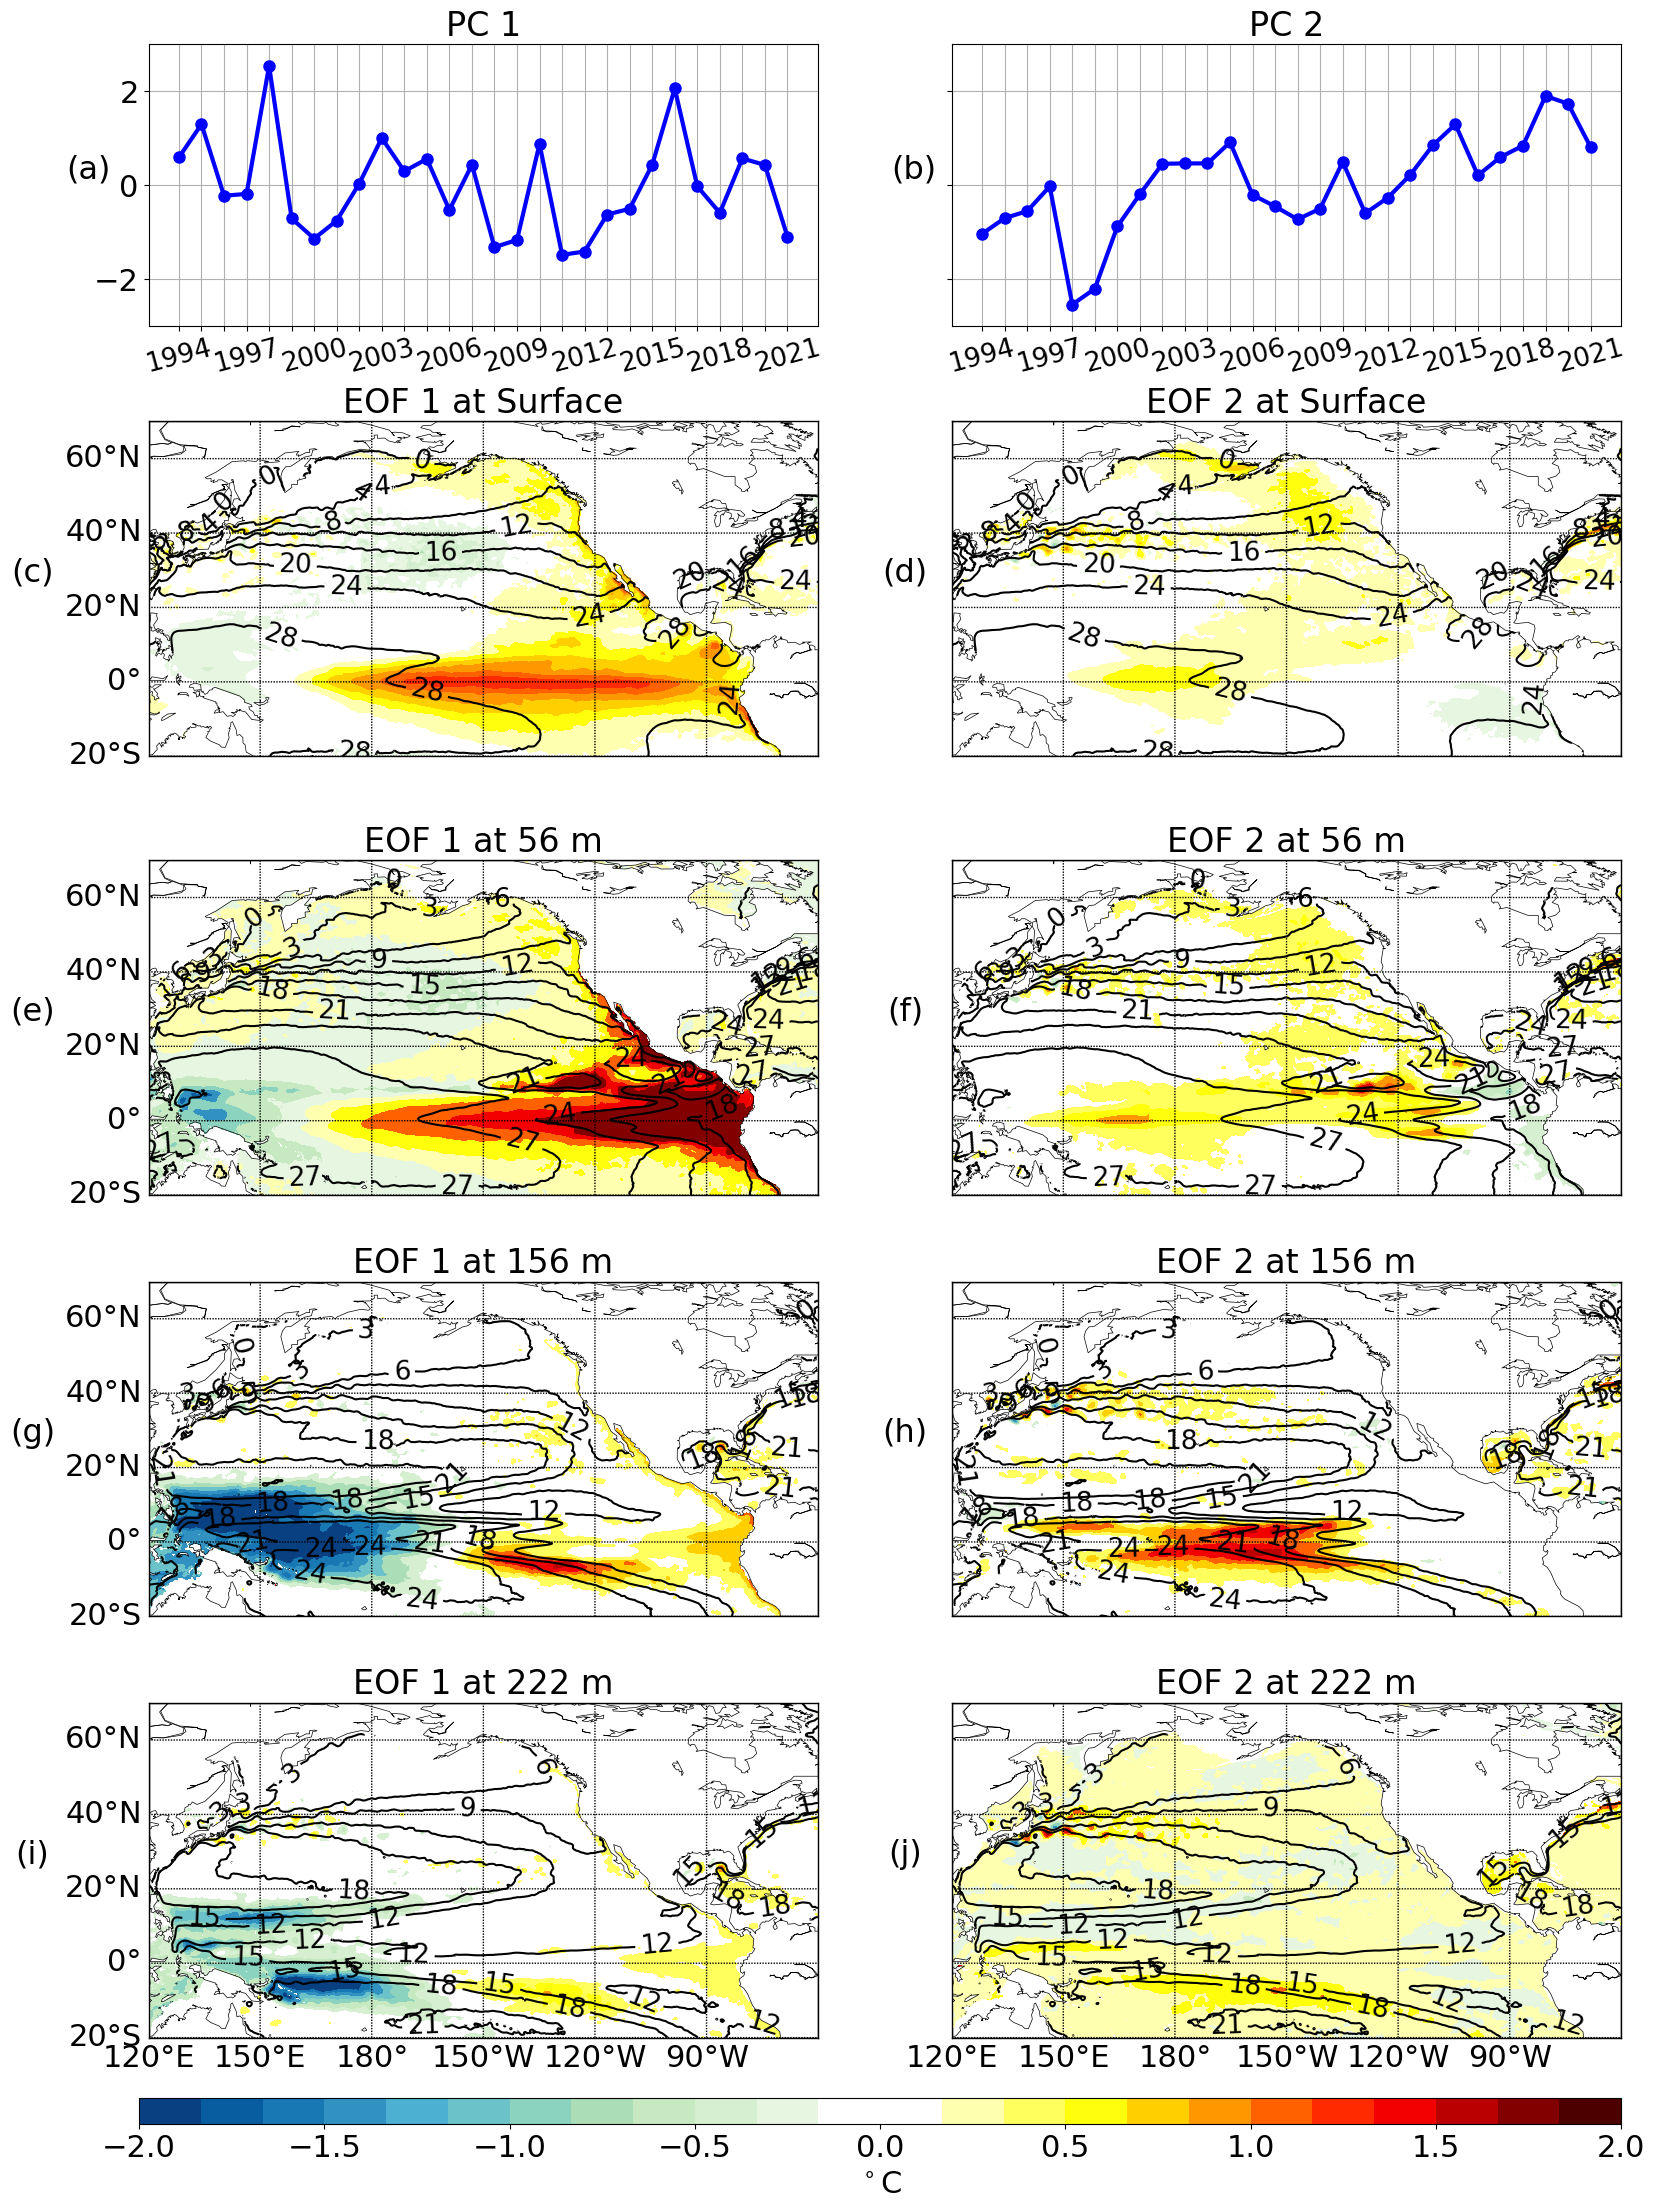

In [161]:
fig = plt.figure(figsize=(19, 26.)) # creating figure 

clip = 2.0          # the maximum and minimum for the colorbar
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
number_bins  = 12   # specifies the number of colors for each half of the diveriging colorbar
num_contours = 10   # Specifies the number of climatology contours


newcmp2 = create_colormap(number_bins) # create colormap

title_sz = 24
label_sz = title_sz - 2
tick_sz = 5
line = 3

# Create a GridSpec layout with different widths for the first and second columns
gs = GridSpec(5, 2, height_ratios=[.8, 1.1, 1, 1, 1])  # Adjust the first subplot width with a larger ratio
###################################################################
###################################################################
# First row
ax = fig.add_subplot(gs[0, 0])
plt.ylabel('(a)', rotation='horizontal', size=title_sz-1)

# plot time series
mode = 1
plt.plot(years, eigvecs[:,mode-1],'b', marker = 'o',label = 'PC with Cov', linewidth=line, markersize = line+5)

# formatting ticks and axes labels
plt.xticks(years)
plt.xticks(rotation=15)
plt.xticks(fontsize = 17)
plt.ylim([-3,3])
plt.yticks(fontsize = 17)
plt.title('PC ' + str(mode), fontsize=title_sz)
ax.set_xticklabels([])
ax.tick_params(axis='y', labelsize=label_sz)  # You can set any size you want
plt.grid(True)

# Get the current ticks
xticks = ax.get_xticks()

# Set labels for every other tick, leave others blank
xtick_labels = [str(int(tick)) if i % 3 == 0 else '' for i, tick in enumerate(xticks)]
ax.set_xticklabels(xtick_labels)
ax.tick_params(axis='x', labelsize=label_sz-3)  # You can set any size you want

###################################################################
ax = fig.add_subplot(gs[0, 1])
plt.ylabel('(b)', rotation='horizontal', size=title_sz-1, labelpad = 20)

mode = 2
plt.plot(years, eigvecs[:,mode-1],'b', marker = 'o',label = 'PC with Cov', linewidth=line, markersize = line+5)

plt.xticks(years)
plt.xticks(rotation=15)
plt.xticks(fontsize = 17)
plt.ylim([-3,3])
plt.yticks(fontsize = 17)
plt.title('PC ' + str(mode), fontsize=title_sz)
plt.grid(True)
ax.tick_params(axis='y', labelsize=label_sz)  # You can set any size you want
ax.set_yticklabels([])

# Get the current ticks
xticks = ax.get_xticks()

# Set labels for every other tick, leave others blank
xtick_labels = [str(int(tick)) if i % 3 == 0 else '' for i, tick in enumerate(xticks)]
ax.set_xticklabels(xtick_labels)
ax.tick_params(axis='x', labelsize=label_sz-3)  # You can set any size you want
###################################################################
###################################################################
# Second row 
ax = fig.add_subplot(gs[1, 0])
plt.ylabel('(c)', rotation='horizontal', size=title_sz-1, labelpad=80)

depth_ind = 0               # specify depth to plot
dat = EOF1[depth_ind, :, :] 
dat = np.maximum(np.minimum(dat, clip), -clip)  # clip min and max values
plt.title(f"EOF 1 at Surface", size=title_sz)   # add title

# adding map
mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

# climatology contours
dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
ax = fig.add_subplot(gs[1, 1])
plt.ylabel('(d)', rotation='horizontal', size=title_sz-1, labelpad = 30)

dat = EOF2[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"EOF 2 at Surface", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)

###################################################################
###################################################################
# Third row 
ax = fig.add_subplot(gs[2, 0])
plt.ylabel('(e)', rotation='horizontal', size=title_sz-1, labelpad = 80)

depth_ind = 18
dat = EOF1[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"EOF 1 at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

# climatologies
dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
ax = fig.add_subplot(gs[2, 1])
plt.ylabel('(f)', rotation='horizontal', size=title_sz-1, labelpad = 30)

dat = EOF2[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"EOF 2 at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)

###################################################################
###################################################################
# Third row 
ax = fig.add_subplot(gs[3, 0])
plt.ylabel('(g)', rotation='horizontal', size=title_sz-1, labelpad = 80)

depth_ind = 24
dat = EOF1[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"EOF 1 at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
ax = fig.add_subplot(gs[3, 1])
plt.ylabel('(h)', rotation='horizontal', size=title_sz-1, labelpad = 30)

dat = EOF2[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"EOF 2 at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)

###################################################################
###################################################################
# Fourth row 
ax = fig.add_subplot(gs[4, 0])
plt.ylabel('(i)', rotation='horizontal', size=title_sz-1, labelpad = 80)

depth_ind = 26
dat = EOF1[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"EOF 1 at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
# Fourth subplot
ax = fig.add_subplot(gs[4, 1])
plt.ylabel('(j)', rotation='horizontal', size=title_sz-1, labelpad= 30)


dat = EOF2[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"EOF 2 at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
# Colorbar settings remain unchanged
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
cax = fig.add_axes([0.12, 0.08, 0.78, 0.01]) #(left, bottom, width, height)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, cax = cax, orientation='horizontal')
cbar.ax.set_title("$^\circ$C", fontsize = label_sz, y=-3, loc = 'center')
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.update_ticks()
plt.show()

### Figure 2

C:\Users\Dani\AppData\Local\Temp\ipykernel_30156\2216091144.py:18: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(Z, axis = 1)
C:\Users\Dani\AppData\Local\Temp\ipykernel_30156\2216091144.py:75: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(Z, axis = 1)


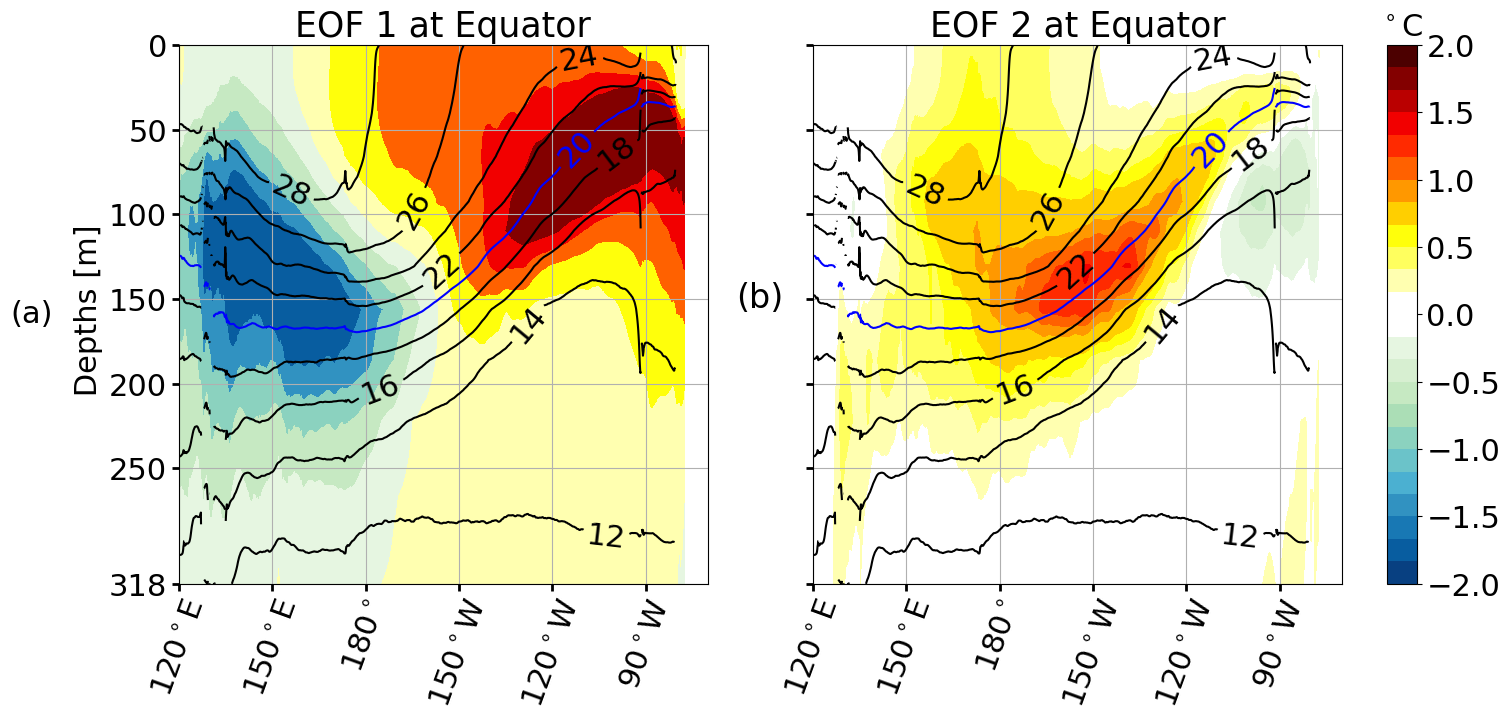

In [183]:
fig = plt.figure(figsize=(15.,7.))

title_sz = 25
label_sz = title_sz-3
tick_sz = 5

lat_ind = 240        # equator
lat_cut_start = 180  # 5S
lat_cut_end   = 301  # 5N
lon_cut_start = 0    # 120E
lon_cut_end   = 2040 # 70W
depth_cut_end = 29   # 318.12 meters
#########################################################################################
ax = fig.add_subplot(1,2,1)
name = 'EOF 1' # for title

Z = EOF1[:depth_cut_end, lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end] # plot as average around equator 
Z = np.nanmean(Z, axis = 1)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
surface = np.clip(Z, -clip, clip) # cut off values at that limit

# plot the cross section
plt.contourf(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], surface, number_bins, norm = norm, cmap = newcmp2)

# plotting climatology contours
specific_levels = [12, 14, 16, 18, 22, 24, 26, 28]
Z = clim[:depth_cut_end, lat_ind, lon_cut_start:lon_cut_end] # plot first 13 depths
CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z, levels=specific_levels, colors='k')
plt.clabel(CS, inline=True, fontsize=label_sz)
# plotting thermocline in blue
CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z, levels=[20], colors='b')
manual_locations = [
    (240,-50)
]
plt.clabel(CS, inline=True, fontsize=label_sz, manual=manual_locations)


# label format
# lat
lat_name = get_lat_names(lat_ind)

# depth 
step = 50
y_labels = plt.yticks()
dep_names = np.arange(0,-y_labels[0][0],step).astype(int)
dep_names[-1] = depths.astype(int)[28]
plt.yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = label_sz)
plt.ylabel(' Depths [m]', size =label_sz)

# lon
lon_name = [] 
spacing = 30 # specify spacing between longitude labels and ticks
for ii in lon[lon_cut_start:lon_cut_end:12*spacing]:
    ii = int(ii) # round to int so that names do not contain decimals
    lon_name.append(convert_longitude(ii)) # append name to list

plt.xticks(lon[lon_cut_start:lon_cut_end:12*spacing], lon_name, fontsize = label_sz)
plt.xticks(rotation=70)
plt.title(f"{name} at {lat_name}", size = title_sz)
plt.grid(True)

# tick width and length formatting
ax.tick_params(axis='y', which='both', length=tick_sz, width=2)
ax.tick_params(axis='x', which='both', length=tick_sz, width=2)


ax.text(-.32, 0.5, "(a)", transform=ax.transAxes, va='center', fontsize = label_sz)

###################################################################
ax = fig.add_subplot(1,2,2)
name = 'EOF 2'

Z = EOF2[:depth_cut_end, lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end] # plot at lat 10 south only first 13 depths
Z = np.nanmean(Z, axis = 1)

surface = np.clip(Z, -clip, clip) # cut off values at that limit

plt.contourf(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], surface, number_bins, norm = norm, cmap = newcmp2)


Z = clim[:depth_cut_end, lat_ind, lon_cut_start:lon_cut_end] # plot at lat 10 south only first 13 depths
CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z, levels=specific_levels, colors='k')

plt.clabel(CS, inline=True, fontsize=label_sz)
CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z, levels=[20], colors='b')
manual_locations = [
    (240,-50)
    # Add more positions as needed
]
plt.clabel(CS, inline=True, fontsize=label_sz, manual=manual_locations)

lat_name = get_lat_names(lat_ind)


# label format
step = 50
y_labels = plt.yticks()
dep_names = np.arange(0,-y_labels[0][0],step).astype(int)
dep_names[-1] = depths.astype(int)[28]
plt.yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = label_sz)


lon_name = [] # initialize string list
spacing = 30
for ii in lon[lon_cut_start:lon_cut_end:12*spacing]:
    ii = int(ii) # round to int so that names do not contain decimals
    lon_name.append(convert_longitude(ii)) # append name to list

plt.xticks(lon[lon_cut_start:lon_cut_end:12*spacing], lon_name, fontsize = label_sz)
plt.xticks(rotation=70)
plt.title(f"{name} at {lat_name}", size = title_sz)
plt.grid(True)

# label format
ax.tick_params(axis='y', which='both', length=tick_sz, width=2)
ax.tick_params(axis='x', which='both', length=tick_sz, width=2)
ax.set_yticklabels([])  # Remove y tick labels
plt.ylabel('(b)', rotation='horizontal', size=title_sz-1, labelpad= 30)
######################################################################################
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)

cax = fig.add_axes([.93, 0.11, 0.02, 0.77]) #(left, bottom, width, height)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, cax = cax)
cbar.ax.set_title("$^\circ$C", fontsize = label_sz)
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.update_ticks()

## Section 2: E and C index plots

In [136]:
C = (eigvecs[:,0] + eigvecs[:,1])/np.sqrt(2)
E = (eigvecs[:,0] - eigvecs[:,1])/np.sqrt(2)
C_EOF = (EOF1 + EOF2)/np.sqrt(2)
E_EOF = (EOF1 - EOF2)/np.sqrt(2)

### Figure 3

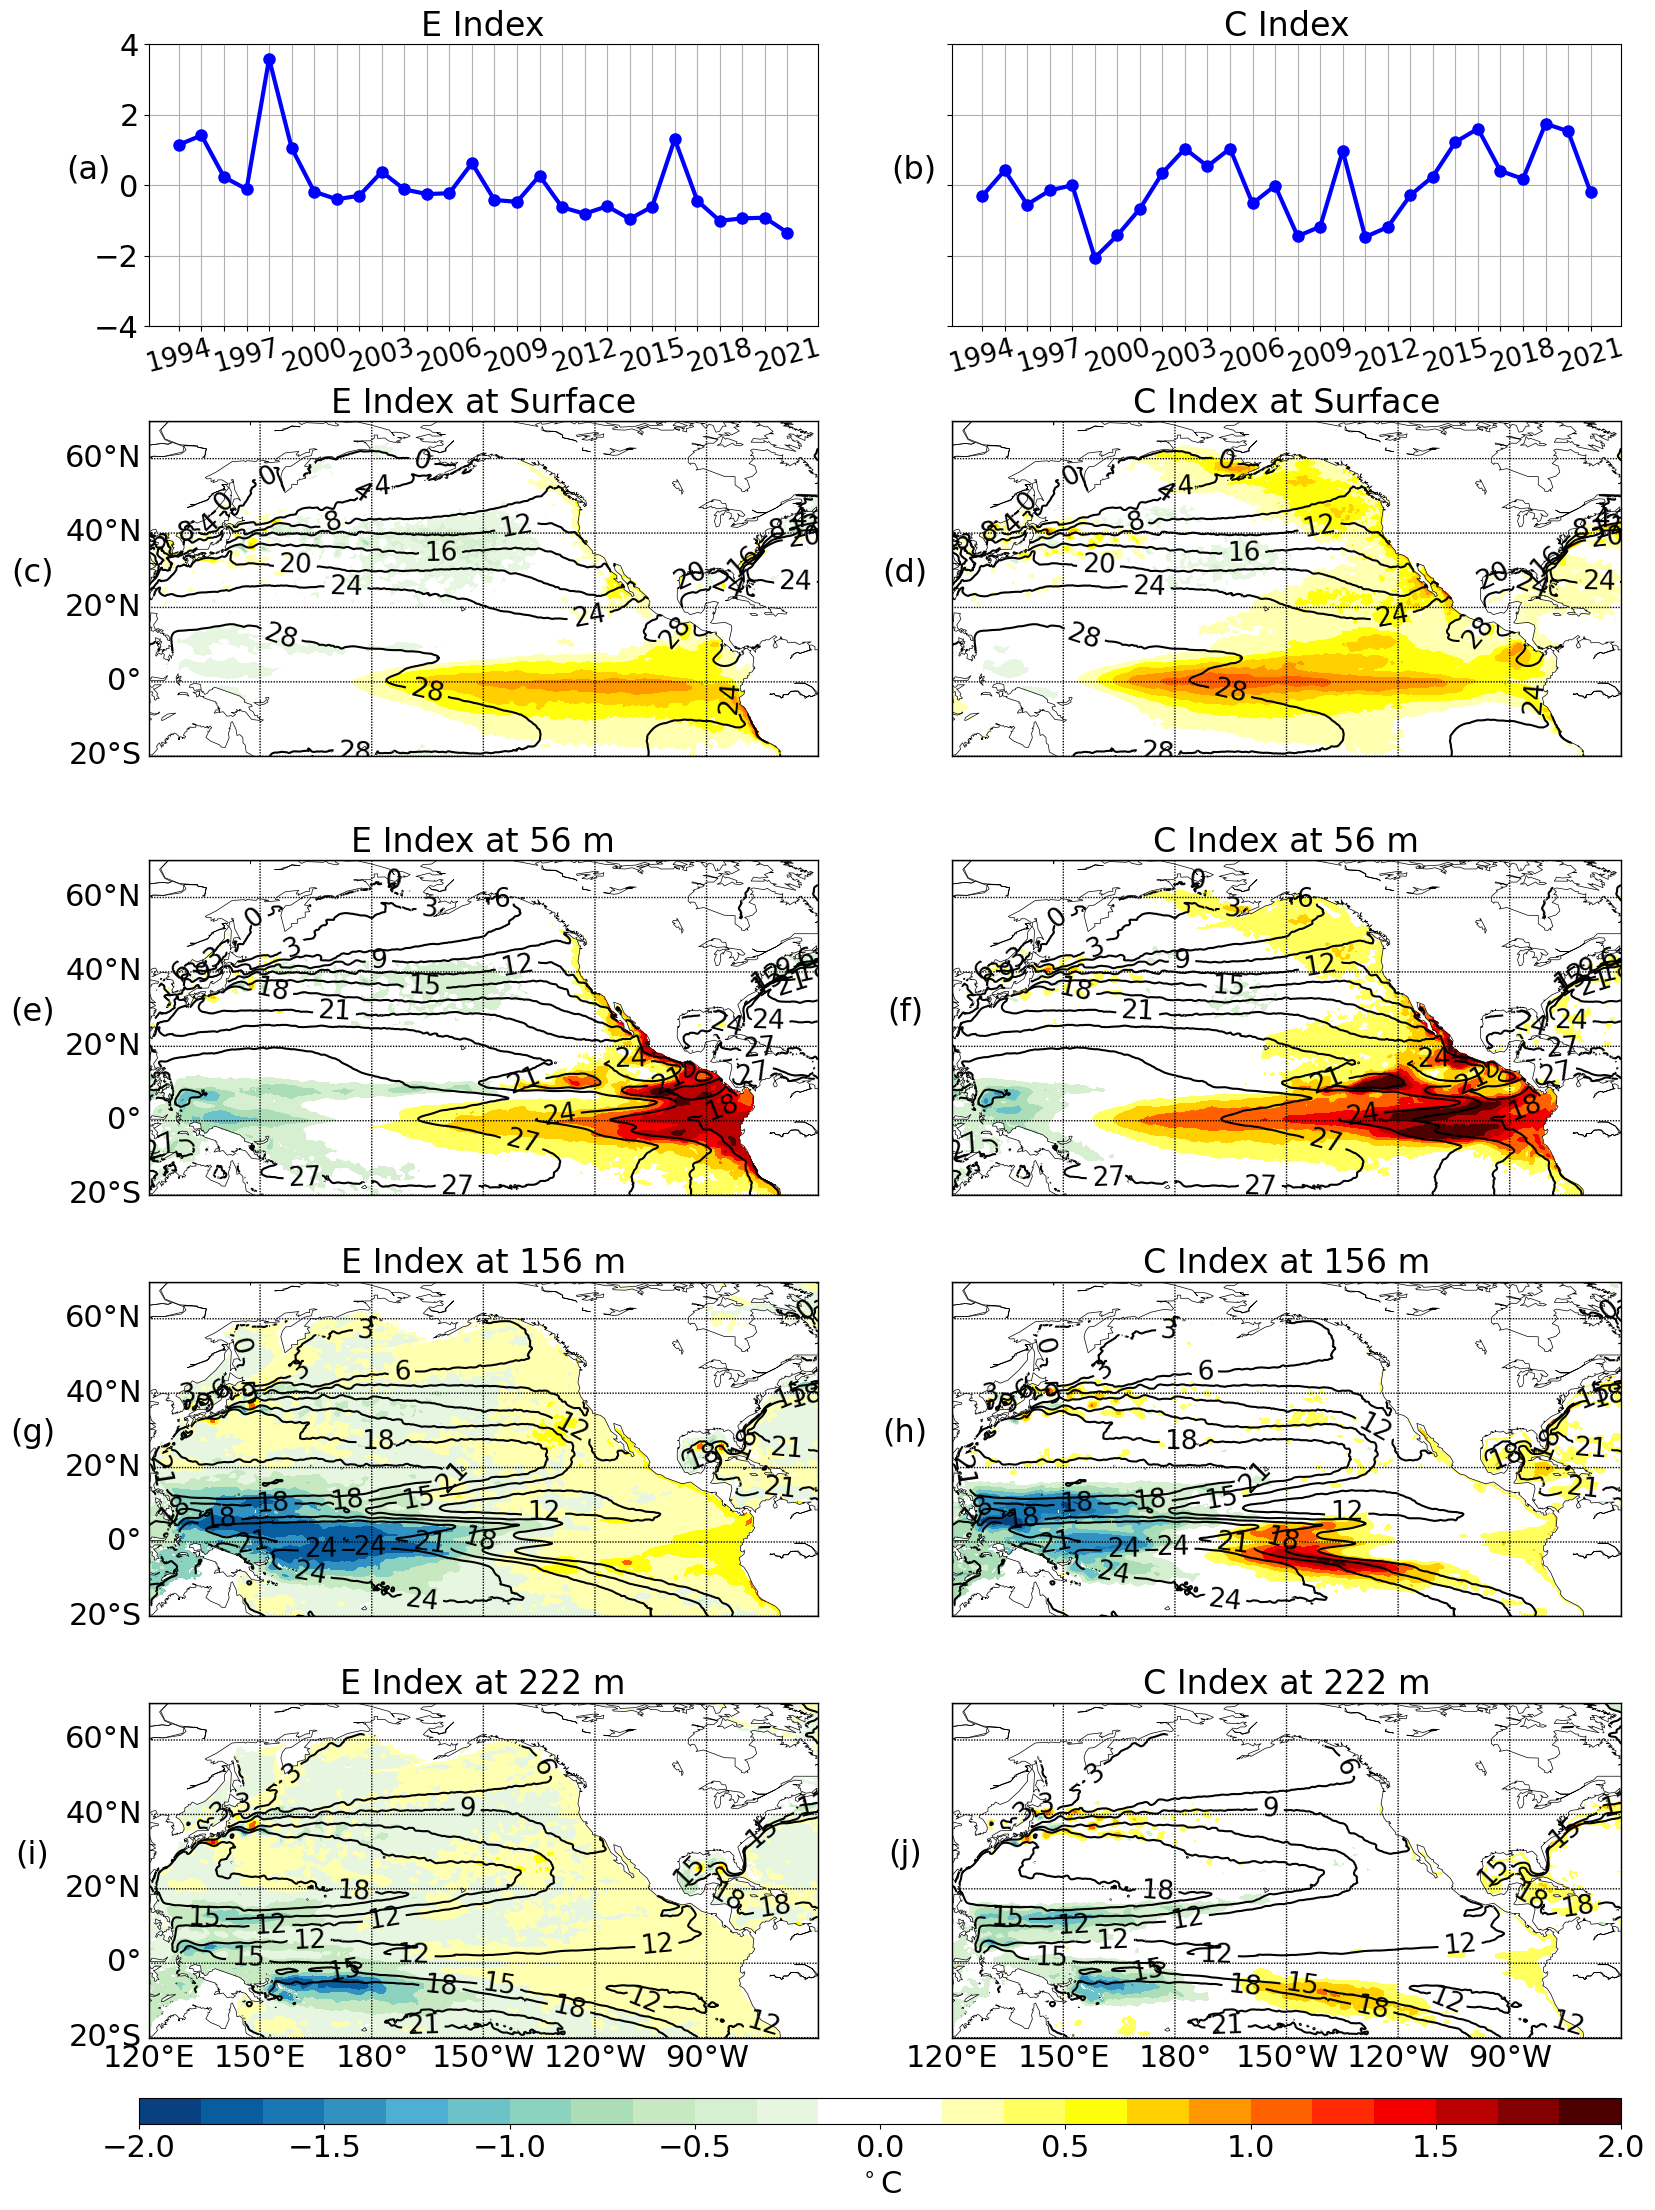

In [140]:
fig = plt.figure(figsize=(19, 26.)) # creating figure 

clip = 2.0          # the maximum and minimum for the colorbar
number_bins  = 12   # specifies the number of colors for each half of the diveriging colorbar
num_contours = 10   # Specifies the number of climatology contours

newcmp2 = create_colormap(number_bins) # create colormap
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip) # set limits for colormap

title_sz = 24
label_sz = title_sz - 2
tick_sz = 5
line = 3

# Create a GridSpec layout with different widths for the first and second columns
gs = GridSpec(5, 2, height_ratios=[.8, 1.1, 1, 1, 1])  # Adjust the first subplot width with a larger ratio
###################################################################
###################################################################
# First row
ax = fig.add_subplot(gs[0, 0])
plt.ylabel('(a)', rotation='horizontal', size=title_sz-1)

# Plot time series
plt.plot(years, E,'b', marker = 'o',linewidth=line, markersize = line+5)

# formatting labels
plt.xticks(years)
plt.xticks(rotation=15)
plt.xticks(fontsize = 17)
plt.ylim([-4,4])
plt.yticks(fontsize = 17)
plt.title('E Index', fontsize=title_sz)
ax.set_xticklabels([])
ax.tick_params(axis='y', labelsize=label_sz)  # You can set any size you want
plt.grid(True)

# Get the current ticks
xticks = ax.get_xticks()

# Set labels for every other tick, leave others blank
xtick_labels = [str(int(tick)) if i % 3 == 0 else '' for i, tick in enumerate(xticks)]
ax.set_xticklabels(xtick_labels)
ax.tick_params(axis='x', labelsize=label_sz-3)  # You can set any size you want

###################################################################
ax = fig.add_subplot(gs[0, 1])
plt.ylabel('(b)', rotation='horizontal', size=title_sz-1, labelpad = 20)

plt.plot(years, C,'b', marker = 'o',linewidth=line, markersize = line+5)

plt.xticks(years)
plt.xticks(rotation=15)
plt.xticks(fontsize = 17)
plt.ylim([-4,4])
plt.yticks(fontsize = 17)
plt.title('C Index', fontsize=title_sz)
plt.grid(True)
ax.tick_params(axis='y', labelsize=label_sz)  # You can set any size you want
ax.set_yticklabels([])

# Get the current ticks
xticks = ax.get_xticks()

# Set labels for every other tick, leave others blank
xtick_labels = [str(int(tick)) if i % 3 == 0 else '' for i, tick in enumerate(xticks)]
ax.set_xticklabels(xtick_labels)
ax.tick_params(axis='x', labelsize=label_sz-3)  # You can set any size you want
###################################################################
###################################################################
# Second row 
ax = fig.add_subplot(gs[1, 0])
plt.ylabel('(c)', rotation='horizontal', size=title_sz-1, labelpad=80)

depth_ind = 0
dat = E_EOF[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)  # clamp min and max values
plt.title(f"E Index at Surface", size=title_sz)

# adding map
mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

# climatologies
dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
ax = fig.add_subplot(gs[1, 1])
plt.ylabel('(d)', rotation='horizontal', size=title_sz-1, labelpad = 30)

dat = C_EOF[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"C Index at Surface", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)

###################################################################
###################################################################
# Third row 
ax = fig.add_subplot(gs[2, 0])
plt.ylabel('(e)', rotation='horizontal', size=title_sz-1, labelpad = 80)

depth_ind = 18
dat = E_EOF[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"E Index at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

# climatologies
dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
ax = fig.add_subplot(gs[2, 1])
plt.ylabel('(f)', rotation='horizontal', size=title_sz-1, labelpad = 30)

dat = C_EOF[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"C Index at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)

###################################################################
###################################################################
# Third row 
ax = fig.add_subplot(gs[3, 0])
plt.ylabel('(g)', rotation='horizontal', size=title_sz-1, labelpad = 80)

depth_ind = 24
dat = E_EOF[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"E Index at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
ax = fig.add_subplot(gs[3, 1])
plt.ylabel('(h)', rotation='horizontal', size=title_sz-1, labelpad = 30)

dat = C_EOF[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"C Index at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 0], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)

###################################################################
###################################################################
# Fourth row 
ax = fig.add_subplot(gs[4, 0])
plt.ylabel('(i)', rotation='horizontal', size=title_sz-1, labelpad = 80)

depth_ind = 26
dat = E_EOF[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"E Index at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[1, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
# Fourth subplot
ax = fig.add_subplot(gs[4, 1])
plt.ylabel('(j)', rotation='horizontal', size=title_sz-1, labelpad= 30)


dat = C_EOF[depth_ind, :, :]
dat = np.maximum(np.minimum(dat, clip), -clip)
plt.title(f"C Index at {round(depths[depth_ind])} m", size=title_sz)

mymap = Basemap(projection='cyl', llcrnrlat=lat[0], urcrnrlat=lat[-1],
                llcrnrlon=lon[0], urcrnrlon=lon[-1], resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[0], lat[-1], 20), labels=[0, 0, 0, 0], fontsize=label_sz)
mymap.drawmeridians(np.arange(lon[0], lon[-1], 30), labels=[0, 0, 0, 1], fontsize=label_sz)

ax.contourf(lon, lat, dat, number_bins, cmap=newcmp2, norm = norm)

dat = clim[depth_ind, :, :]
CS = ax.contour(lon, lat, dat, colors='k', levels=num_contours)
ax.clabel(CS, inline=True, fontsize=label_sz - 3)
###################################################################
# Colorbar settings remain unchanged
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
cax = fig.add_axes([0.12, 0.08, 0.78, 0.01]) #(left, bottom, width, height)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, cax = cax, orientation='horizontal')
cbar.ax.set_title("$^\circ$C", fontsize = label_sz, y=-3, loc = 'center')
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.update_ticks()
plt.show()

### Figure 4

C:\Users\Dani\AppData\Local\Temp\ipykernel_30156\823947512.py:18: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(Z, axis = 1)
C:\Users\Dani\AppData\Local\Temp\ipykernel_30156\823947512.py:75: RuntimeWarning: Mean of empty slice
  Z = np.nanmean(Z, axis = 1)


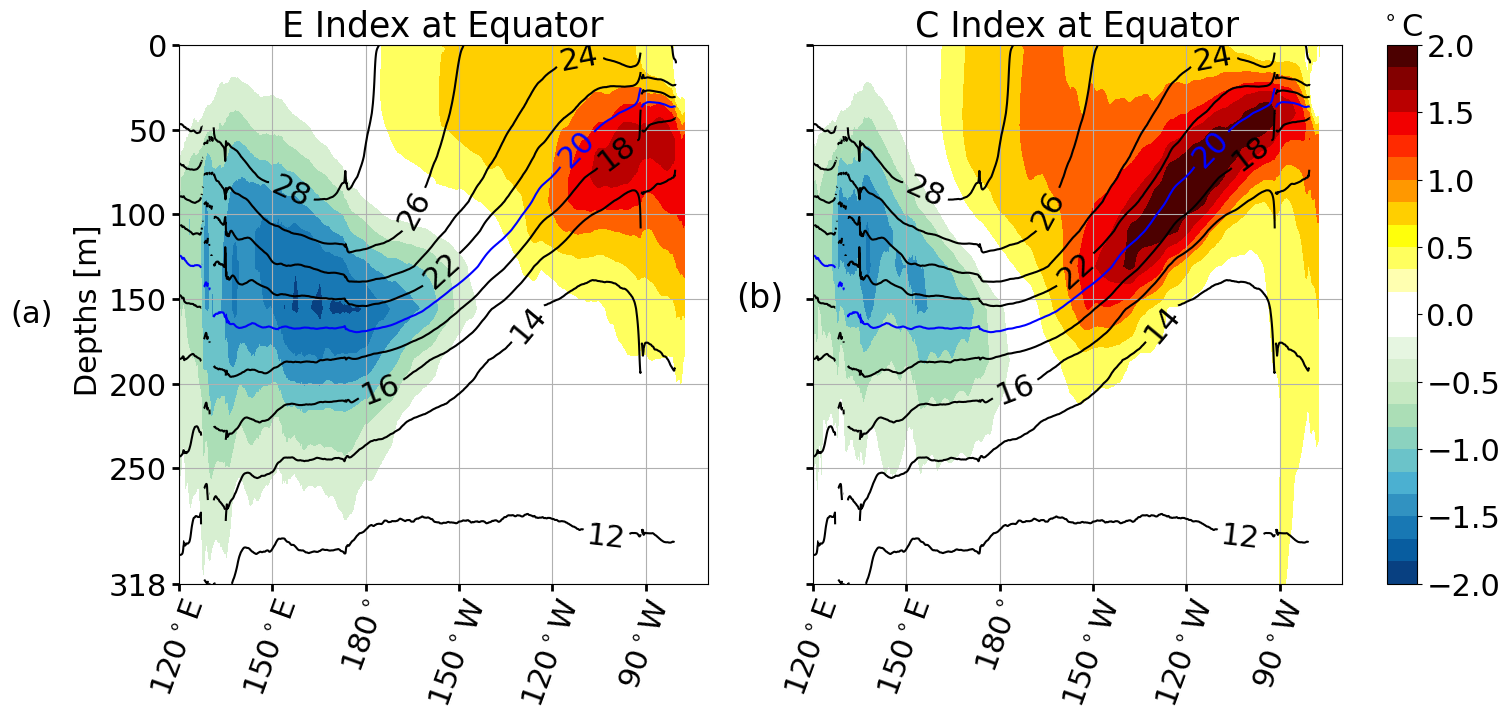

In [185]:
fig = plt.figure(figsize=(15.,7.))

title_sz = 25
label_sz = title_sz-3
tick_sz = 5

lat_ind = 240        # equator
lat_cut_start = 180  # 5S
lat_cut_end   = 301  # 5N
lon_cut_start = 0    # 120E
lon_cut_end   = 2040 # 70W
depth_cut_end = 29   # 318.12 meters
#########################################################################################
ax = fig.add_subplot(1,2,1)
name = 'E Index' # for title

Z = E_EOF[:depth_cut_end, lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end] # plot as average around equator 
Z = np.nanmean(Z, axis = 1)

norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
surface = np.clip(Z, -clip, clip) # cut off values at that limit

# plot the cross section
plt.contourf(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], surface, number_bins, norm = norm, cmap = newcmp2)

# plotting climatology contours
specific_levels = [12, 14, 16, 18, 22, 24, 26, 28]
Z = clim[:depth_cut_end, lat_ind, lon_cut_start:lon_cut_end] # plot first 13 depths
CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z, levels=specific_levels, colors='k')
plt.clabel(CS, inline=True, fontsize=label_sz)
# plotting thermocline in blue
CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z, levels=[20], colors='b')
manual_locations = [
    (240,-50)
]
plt.clabel(CS, inline=True, fontsize=label_sz, manual=manual_locations)


# label format
# lat
lat_name = get_lat_names(lat_ind)

# depth 
step = 50
y_labels = plt.yticks()
dep_names = np.arange(0,-y_labels[0][0],step).astype(int)
dep_names[-1] = depths.astype(int)[28]
plt.yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = label_sz)
plt.ylabel(' Depths [m]', size =label_sz)

# lon
lon_name = [] 
spacing = 30 # specify spacing between longitude labels and ticks
for ii in lon[lon_cut_start:lon_cut_end:12*spacing]:
    ii = int(ii) # round to int so that names do not contain decimals
    lon_name.append(convert_longitude(ii)) # append name to list

plt.xticks(lon[lon_cut_start:lon_cut_end:12*spacing], lon_name, fontsize = label_sz)
plt.xticks(rotation=70)
plt.title(f"{name} at {lat_name}", size = title_sz)
plt.grid(True)

# tick width and length formatting
ax.tick_params(axis='y', which='both', length=tick_sz, width=2)
ax.tick_params(axis='x', which='both', length=tick_sz, width=2)


ax.text(-.32, 0.5, "(a)", transform=ax.transAxes, va='center', fontsize = label_sz)

###################################################################
ax = fig.add_subplot(1,2,2)
name = 'C Index'

Z = C_EOF[:depth_cut_end, lat_cut_start:lat_cut_end, lon_cut_start:lon_cut_end] # plot at lat 10 south only first 13 depths
Z = np.nanmean(Z, axis = 1)

surface = np.clip(Z, -clip, clip) # cut off values at that limit

plt.contourf(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], surface, number_bins, norm = norm, cmap = newcmp2)


Z = clim[:depth_cut_end, lat_ind, lon_cut_start:lon_cut_end] # plot at lat 10 south only first 13 depths
CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z, levels=specific_levels, colors='k')

plt.clabel(CS, inline=True, fontsize=label_sz)
CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z, levels=[20], colors='b')
manual_locations = [
    (240,-50)
    # Add more positions as needed
]
plt.clabel(CS, inline=True, fontsize=label_sz, manual=manual_locations)

lat_name = get_lat_names(lat_ind)


# label format
step = 50
y_labels = plt.yticks()
dep_names = np.arange(0,-y_labels[0][0],step).astype(int)
dep_names[-1] = depths.astype(int)[28]
plt.yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = label_sz)


lon_name = [] # initialize string list
spacing = 30
for ii in lon[lon_cut_start:lon_cut_end:12*spacing]:
    ii = int(ii) # round to int so that names do not contain decimals
    lon_name.append(convert_longitude(ii)) # append name to list

plt.xticks(lon[lon_cut_start:lon_cut_end:12*spacing], lon_name, fontsize = label_sz)
plt.xticks(rotation=70)
plt.title(f"{name} at {lat_name}", size = title_sz)
plt.grid(True)

# label format
ax.tick_params(axis='y', which='both', length=tick_sz, width=2)
ax.tick_params(axis='x', which='both', length=tick_sz, width=2)
ax.set_yticklabels([])  # Remove y tick labels
plt.ylabel('(b)', rotation='horizontal', size=title_sz-1, labelpad= 30)
######################################################################################
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)

cax = fig.add_axes([.93, 0.11, 0.02, 0.77]) #(left, bottom, width, height)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, cax = cax)
cbar.ax.set_title("$^\circ$C", fontsize = label_sz)
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.update_ticks()

## Section 3: Regional Plots

### Figure 5

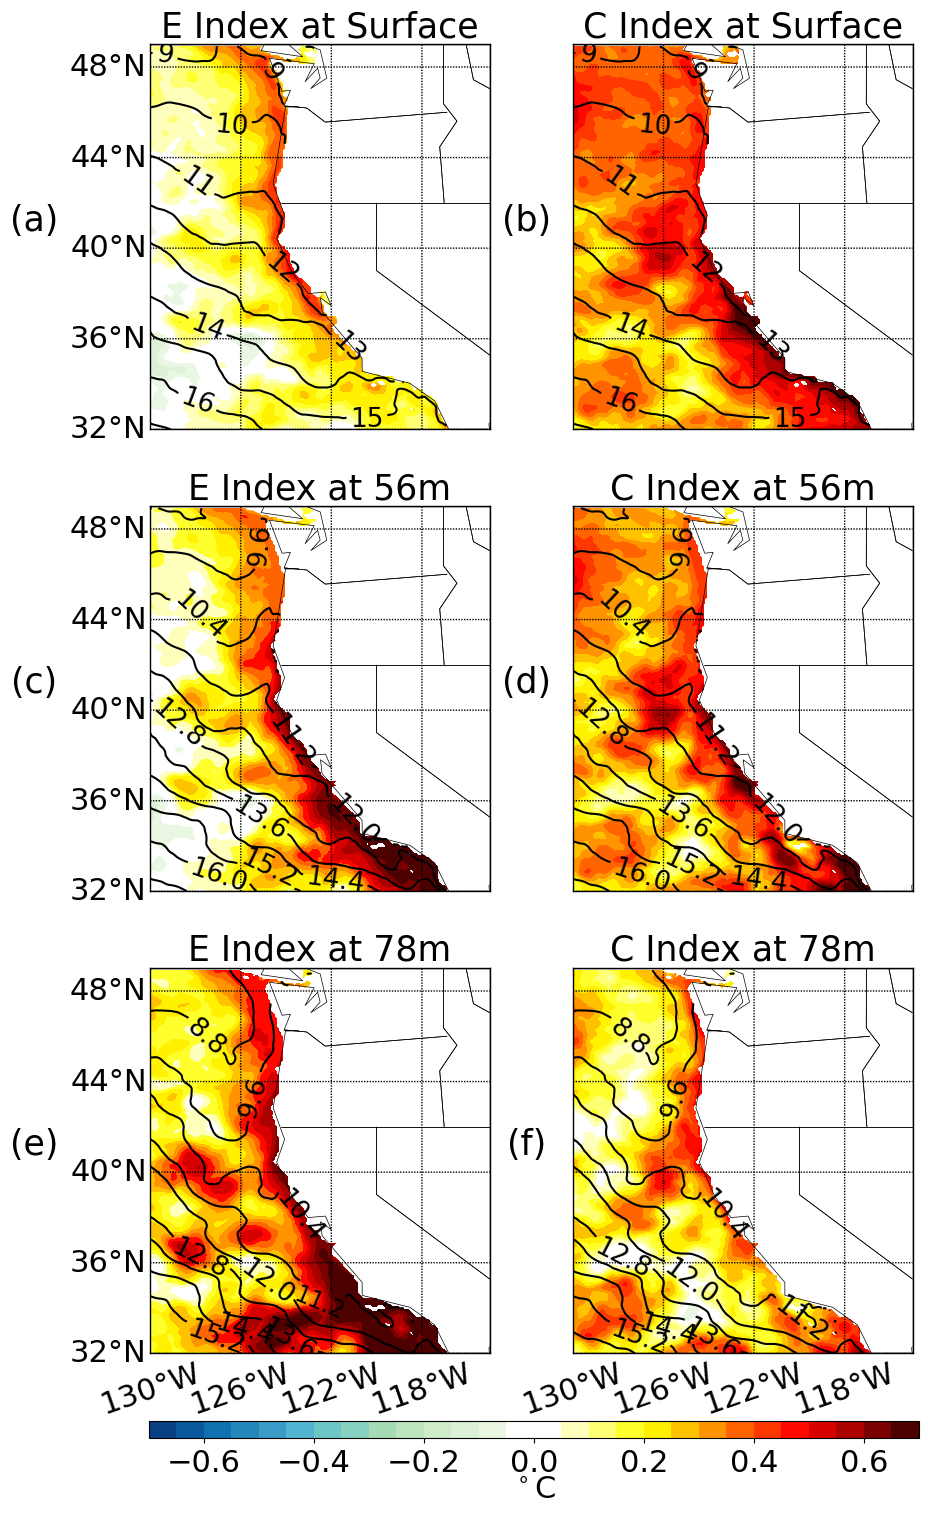

In [153]:
# specifying the U.S West Coast
lat_cut_start = 624
lat_cut_end   = 828
lon_cut_start = 1320
lon_cut_end   = 1500
clip = .7
lon_spacing = 4

fig = plt.figure(figsize=(10.,17.))
title_sz = 25
label_sz = title_sz-3

number_bins = 14
num_contours = 10

newcmp2 = create_colormap(number_bins) # create colormap
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
#######################################################
depth_ind = 0                  # indicate the depth index
name = 'E Index'               # for the title
ax = fig.add_subplot(3,2,1)    # specify figure's columns, rows, and the position in the figure grid

depth = depths[depth_ind]      # Depth value at index

dat = E_EOF[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end] # cut pattern to specified region
dat = np.maximum(np.minimum(dat, clip), -clip) # clip min and max values

# plot the pattern of the index
plt.contourf(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end],  dat, number_bins, cmap = newcmp2, norm= norm)

# title formatting
if depth_ind == 0:
    plt.title(f"{name} at Surface", size = title_sz)
else:
    plt.title(f"{name} at {round(depth)}m", size = title_sz)

# Plot countour lines for the climatologies
dat = clim[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
CS = plt.contour(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], dat, colors='k', levels=num_contours)
plt.clabel(CS, inline=True, fontsize=label_sz - 3)

# add map
mymap = Basemap(projection='cyl',llcrnrlat=lat[lat_cut_start],urcrnrlat=lat[lat_cut_end],
                llcrnrlon=lon[lon_cut_start],urcrnrlon=lon[lon_cut_end],resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawstates()
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[lat_cut_start],lat[lat_cut_end],4), labels = [1,0,0,0], fontsize = label_sz)
mymap.drawmeridians(np.arange(lon[lon_cut_start],lon[lon_cut_end],lon_spacing), labels = [0,0,0,0], fontsize = label_sz)

plt.ylabel('(a)', rotation = 'horizontal', size = title_sz,labelpad = 80,  loc='center')
##################################################################################################################################
depth_ind = 18
ax = fig.add_subplot(3,2,3)
depth = depths[depth_ind]

dat = E_EOF[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
dat = np.maximum(np.minimum(dat, clip), -clip) 

plt.contourf(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end],  dat, number_bins, cmap = newcmp2, norm= norm)

if depth_ind == 0:
    plt.title(f"{name} at Surface", size = title_sz)
else:
    plt.title(f"{name} at {round(depth)}m", size = title_sz)

dat = clim[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
CS = plt.contour(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], dat, colors='k', levels=num_contours)
plt.clabel(CS, inline=True, fontsize=label_sz - 3)

mymap = Basemap(projection='cyl',llcrnrlat=lat[lat_cut_start],urcrnrlat=lat[lat_cut_end],
                llcrnrlon=lon[lon_cut_start],urcrnrlon=lon[lon_cut_end],resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawstates()
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[lat_cut_start],lat[lat_cut_end],4), labels = [1,0,0,0], fontsize = label_sz)
mymap.drawmeridians(np.arange(lon[lon_cut_start],lon[lon_cut_end],lon_spacing), labels = [0,0,0,0], fontsize = label_sz)

plt.ylabel('(c)', rotation = 'horizontal',  size = title_sz,labelpad = 80, loc='center')
##################################################################################################################################
depth_ind = 20
ax = fig.add_subplot(3,2,5)
depth = depths[depth_ind]

dat = E_EOF[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
dat = np.maximum(np.minimum(dat, clip), -clip) 
plt.contourf(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end],  dat, number_bins, cmap = newcmp2, norm= norm)

if depth_ind == 0:
    plt.title(f"{name} at Surface", size = title_sz)
else:
    plt.title(f"{name} at {round(depth)}m", size = title_sz)

num_contours = 10
dat = clim[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
levels = [8.8, 9.6, 10.4, 12.0, 12.8,13.6, 14.4, 15.2]
CS = plt.contour(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], dat, colors='k', levels=levels)
plt.clabel(CS, inline=True, fontsize=label_sz - 3)

CS = plt.contour(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], dat, levels=[11.2], colors='k')
manual_locations = [
    (237, 34),    # 30°E, 100m depth
    # Add more positions as needed
]
plt.clabel(CS, inline=True, fontsize=label_sz-5, manual=manual_locations)


mymap = Basemap(projection='cyl',llcrnrlat=lat[lat_cut_start],urcrnrlat=lat[lat_cut_end],
                llcrnrlon=lon[lon_cut_start],urcrnrlon=lon[lon_cut_end],resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawstates()
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[lat_cut_start],lat[lat_cut_end],4), labels = [1,0,0,0], fontsize = label_sz)
mymap.drawmeridians(np.arange(lon[lon_cut_start],lon[lon_cut_end],lon_spacing), labels = [0,0,0,1], fontsize = label_sz, rotation = 19)

plt.ylabel('(e)', rotation = 'horizontal',  size = title_sz,labelpad = 80, loc='center')
##################################################################################################################################
###############################################             Plot C Index                ##########################################
##################################################################################################################################
depth_ind = 0
name = 'C Index'
ax = fig.add_subplot(3,2,2)

depth = depths[depth_ind]

dat = C_EOF[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
dat = np.maximum(np.minimum(dat, clip), -clip) 
plt.contourf(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end],  dat, number_bins, cmap = newcmp2, norm= norm)

if depth_ind == 0:
    plt.title(f"{name} at Surface", size = title_sz)
else:
    plt.title(f"{name} at {round(depth)}m", size = title_sz)

dat = clim[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
CS = plt.contour(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], dat, colors='k', levels=num_contours)
plt.clabel(CS, inline=True, fontsize=label_sz - 3)

mymap = Basemap(projection='cyl',llcrnrlat=lat[lat_cut_start],urcrnrlat=lat[lat_cut_end],
                llcrnrlon=lon[lon_cut_start],urcrnrlon=lon[lon_cut_end],resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawstates()
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[lat_cut_start],lat[lat_cut_end],4), labels = [0,0,0,0], fontsize = label_sz)
mymap.drawmeridians(np.arange(lon[lon_cut_start],lon[lon_cut_end],lon_spacing), labels = [0,0,0,0], fontsize = label_sz)

plt.ylabel('(b)', rotation = 'horizontal', size = title_sz,labelpad = 30,  loc='center')
##################################################################################################################################
depth_ind = 18
ax = fig.add_subplot(3,2,4)
depth = depths[depth_ind]

dat = C_EOF[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
dat = np.maximum(np.minimum(dat, clip), -clip) 

plt.contourf(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end],  dat, number_bins, cmap = newcmp2, norm= norm)

if depth_ind == 0:
    plt.title(f"{name} at Surface", size = title_sz)
else:
    plt.title(f"{name} at {round(depth)}m", size = title_sz)

dat = clim[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
CS = plt.contour(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], dat, colors='k', levels=num_contours)
plt.clabel(CS, inline=True, fontsize=label_sz - 3)

mymap = Basemap(projection='cyl',llcrnrlat=lat[lat_cut_start],urcrnrlat=lat[lat_cut_end],
                llcrnrlon=lon[lon_cut_start],urcrnrlon=lon[lon_cut_end],resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawstates()
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[lat_cut_start],lat[lat_cut_end],4), labels = [0,0,0,0], fontsize = label_sz)
mymap.drawmeridians(np.arange(lon[lon_cut_start],lon[lon_cut_end],lon_spacing), labels = [0,0,0,0], fontsize = label_sz)

plt.ylabel('(d)', rotation = 'horizontal',  size = title_sz,labelpad = 30, loc='center')
##################################################################################################################################
depth_ind = 20
ax = fig.add_subplot(3,2,6)
depth = depths[depth_ind]

dat = C_EOF[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
dat = np.maximum(np.minimum(dat, clip), -clip) 

plt.contourf(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end],  dat, number_bins, cmap = newcmp2, norm= norm)

if depth_ind == 0:
    plt.title(f"{name} at Surface", size = title_sz)
else:
    plt.title(f"{name} at {round(depth)}m", size = title_sz)


dat = clim[depth_ind,lat_cut_start:lat_cut_end,lon_cut_start:lon_cut_end]
CS = plt.contour(lon[lon_cut_start:lon_cut_end], lat[lat_cut_start:lat_cut_end], dat, colors='k', levels=num_contours)
plt.clabel(CS, inline=True, fontsize=label_sz - 3)

mymap = Basemap(projection='cyl',llcrnrlat=lat[lat_cut_start],urcrnrlat=lat[lat_cut_end],
                llcrnrlon=lon[lon_cut_start],urcrnrlon=lon[lon_cut_end],resolution='c')
mymap.drawcoastlines(color='black', linewidth=.5)
mymap.drawstates()
mymap.drawmapboundary()
mymap.drawparallels(np.arange(lat[lat_cut_start],lat[lat_cut_end],4), labels = [0,0,0,0], fontsize = label_sz)
mymap.drawmeridians(np.arange(lon[lon_cut_start],lon[lon_cut_end],lon_spacing), labels = [0,0,0,1], fontsize = label_sz, rotation = 19)

plt.ylabel('(f)', rotation = 'horizontal',  size = title_sz,labelpad = 30, loc='center')
##################################################################################################################################
#----------------------------------------------------------------------
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
cax = fig.add_axes([0.13, 0.06, 0.77, 0.01]) #(left, bottom, width, height)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, cax = cax, orientation='horizontal')
cbar.ax.set_title("$^\circ$C",y = -4, loc = 'center', fontsize = label_sz)

cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.update_ticks()

### Figure 6

In [199]:
# Function will plot an EOF zonal cross-section and respective climatology contours
# Input:
#         - EOF: 3D array with the pattern that will be plotted. Could be EOF, E or C index
#         - name: String with name of variable. Used for the title.
#         - clim: 3D array with climatology
#         - lat_ind: int that specifies the latitude for the cross section
#         - lon_start: int that indicates the starting longitude
#         - lon_end: int that indicates the end longitude
#         - depth_cut_end: int specifying end depth
#         - zlim: int specifying the max or min for the colorbar
# Output:
#         - None, but will produce contour plot
def cros_sec_lat_multi(EOF, name, clim, lat_ind, lon_start, lon_end, depth_cut_end, zlim):
    title_sz = 25
    label_sz = title_sz-4
    tick_sz = 5

    Z = EOF[:depth_cut_end, lat_ind, lon_start:lon_end] # plot at lat 
    norm = mpl.colors.Normalize(vmin=-zlim, vmax=zlim)
    surface = np.clip(Z, -zlim, zlim) # cut off values at that limit
    
    plt.contourf(lon[lon_start:lon_end], -depths[:depth_cut_end], surface, number_bins, norm = norm, cmap = newcmp2)

    specific_levels = [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
    Z = clim[:depth_cut_end, lat_ind, lon_cut_start:lon_cut_end]
    CS = plt.contour(lon[lon_cut_start:lon_cut_end], -depths[:depth_cut_end], Z,  colors='k', levels=specific_levels)
    plt.clabel(CS, inline=True, fontsize=label_sz)

    
    lat_name = get_lat_names(lat_ind)
        
    # label format
    # depth
    y_labels = plt.yticks()  # get depth labels
    dep_names = np.arange(0,-y_labels[0][0],step).astype(int)   # set depths at interval of steps
    dep_names[-1] = depths[:depth_cut_end].astype(int)[-1]  # set last depth as its value
    plt.yticks(-dep_names, dep_names.astype(str).tolist(), fontsize = label_sz) # implement depth labels
    
    # longituge
    lon_name, spacing = get_lon_names(lon_start, lon_end)
    plt.xticks(lon[lon_start:lon_end:12*spacing], lon_name, fontsize = label_sz, rotation = 15)
    
    plt.title(f"{name} at {lat_name}", size = title_sz)
    plt.grid(True)


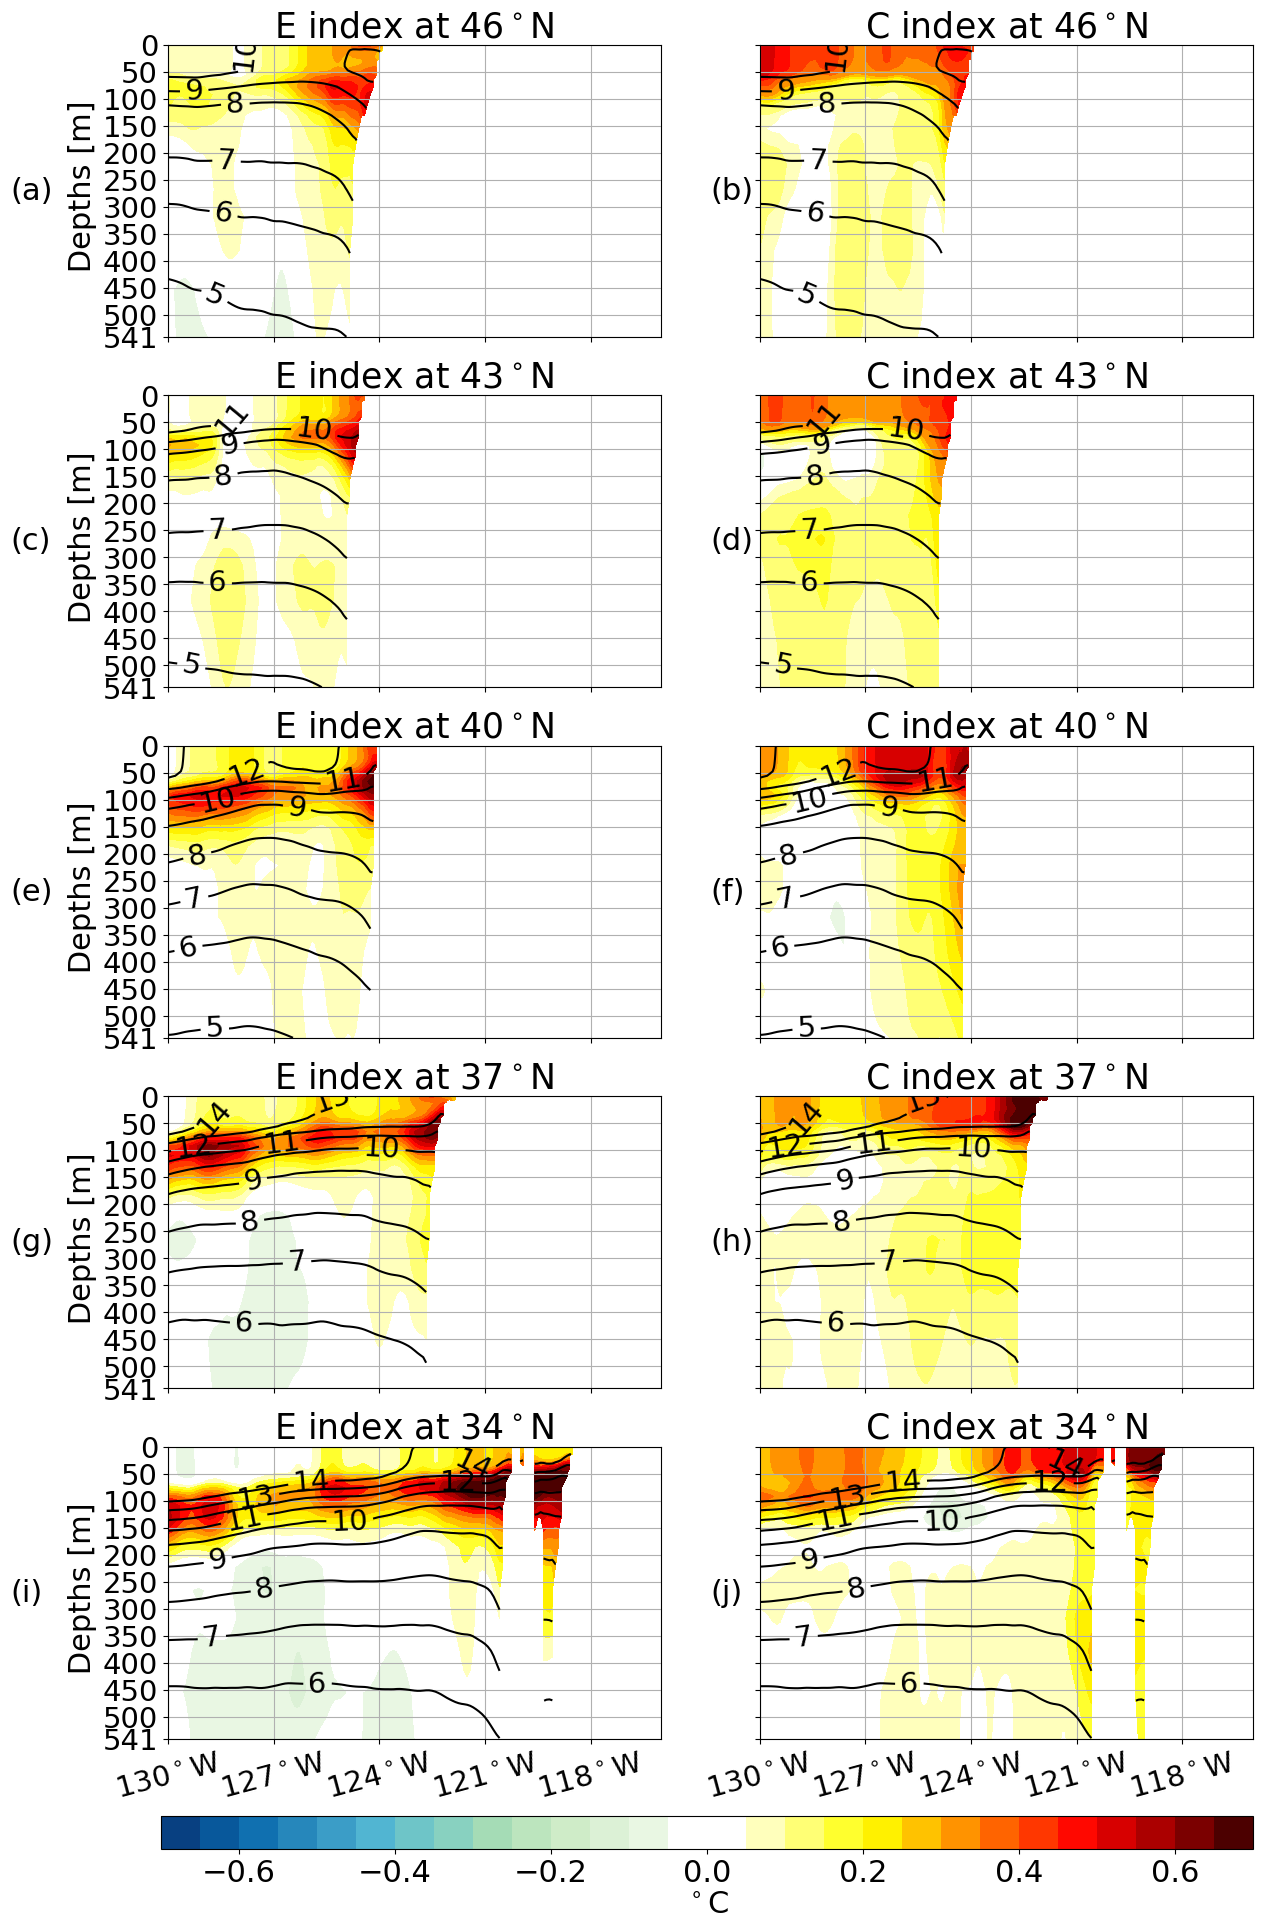

In [207]:
fig = plt.figure(figsize=(14., 22.))

title_sz = 25
label_sz = title_sz-3
tick_sz = 5

lat_cut_start = 648
lon_cut_start = 1320
lon_cut_end   = 1489
depth_cut_end = 32
step = 50

clip = .7


number_bins = 14
num_contours = 10

newcmp2 = create_colormap(number_bins) # create colormap
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)

###################################################################################
ax = fig.add_subplot(5,2,1)
lat_ind = lat_cut_start +12*3*4
cros_sec_lat_multi(E_EOF, 'E index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_xticklabels([])  # Remove x tick labels
plt.ylabel(' Depths [m]', size =label_sz)
ax.text(-.32, 0.5, "(a)", transform=ax.transAxes, va='center', fontsize = label_sz)
###################################################################################

ax = fig.add_subplot(5,2,3)
lat_ind = lat_cut_start +12*3*3
cros_sec_lat_multi(E_EOF, 'E index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_xticklabels([])  # Remove x tick labels
plt.ylabel(' Depths [m]', size =label_sz)
ax.text(-.32, 0.5, "(c)", transform=ax.transAxes, va='center', fontsize = label_sz)
###################################################################################

ax = fig.add_subplot(5,2,5)
lat_ind = lat_cut_start+12*3*2
cros_sec_lat_multi(E_EOF, 'E index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_xticklabels([])  # Remove x tick labels
plt.ylabel(' Depths [m]', size =label_sz)
ax.text(-.32, 0.5, "(e)", transform=ax.transAxes, va='center', fontsize = label_sz)
###################################################################################

ax = fig.add_subplot(5,2,7)
lat_ind = lat_cut_start+12*3*1
cros_sec_lat_multi(E_EOF, 'E index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_xticklabels([])  # Remove x tick labels
plt.ylabel(' Depths [m]', size =label_sz)
ax.text(-.32, 0.5, "(g)", transform=ax.transAxes, va='center', fontsize = label_sz)
###################################################################################

ax = fig.add_subplot(5,2,9)
lat_ind = lat_cut_start 
cros_sec_lat_multi(E_EOF, 'E index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
plt.ylabel(' Depths [m]', size =label_sz)
ax.text(-.32, 0.5, "(i)", transform=ax.transAxes, va='center', fontsize = label_sz)

###################################################################################
###################################################################################

ax = fig.add_subplot(5,2,2)
lat_ind = lat_cut_start +12*3*4
cros_sec_lat_multi(C_EOF, 'C index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_xticklabels([])  # Remove x tick labels
ax.set_yticklabels([])  # Remove x tick labels
ax.text(-.1, 0.5, "(b)", transform=ax.transAxes, va='center', fontsize = label_sz)
###################################################################################

ax = fig.add_subplot(5,2,4)
lat_ind = lat_cut_start +12*3*3
cros_sec_lat_multi(C_EOF, 'C index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_xticklabels([])  # Remove x tick labels
ax.set_yticklabels([])  # Remove x tick labels
ax.text(-.1, 0.5, "(d)", transform=ax.transAxes, va='center', fontsize = label_sz)
###################################################################################

ax = fig.add_subplot(5,2,6)
lat_ind = lat_cut_start+12*3*2
cros_sec_lat_multi(C_EOF, 'C index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_xticklabels([])  # Remove x tick labels
ax.set_yticklabels([])  # Remove x tick labels
ax.text(-.1, 0.5, "(f)", transform=ax.transAxes, va='center', fontsize = label_sz)
###################################################################################

ax = fig.add_subplot(5,2,8)
lat_ind = lat_cut_start+12*3*1
cros_sec_lat_multi(C_EOF, 'C index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_xticklabels([])  # Remove x tick labels
ax.set_yticklabels([])  # Remove x tick labels
ax.text(-.1, 0.5, "(h)", transform=ax.transAxes, va='center', fontsize = label_sz)
###################################################################################

ax = fig.add_subplot(5,2,10)
lat_ind = lat_cut_start 
cros_sec_lat_multi(C_EOF, 'C index', clim, lat_ind, lon_cut_start, lon_cut_end, depth_cut_end, clip)
ax.set_yticklabels([])  # Remove x tick labels
ax.text(-.1, 0.5, "(j)", transform=ax.transAxes, va='center', fontsize = label_sz)

###################################################################################
norm = mpl.colors.Normalize(vmin=-clip, vmax=clip)
cax = fig.add_axes([0.12, 0.06, 0.78, 0.015]) # (left, bottom, width, height)
sm = mpl.cm.ScalarMappable(norm=norm, cmap=newcmp2)
sm.set_array([])
cbar = plt.colorbar(sm, cax = cax, orientation='horizontal')

cbar.ax.set_title("$^\circ$C", fontsize = label_sz, y=-2.2, loc = 'center')
cbar.ax.tick_params(labelsize=label_sz)    # set label size of ticks
cbar.update_ticks()